In [195]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [196]:
CONNECTION_AMOUNT=5
PICKLE_FILENAME = 'pickle_data.pkl'

In [197]:
with open(PICKLE_FILENAME, 'rb') as f:
  pickle_dict = pickle.load(f)
ws_raw_data = pd.DataFrame.from_dict(pickle_dict)
ws_raw_data.head()

,receive_time,connection_name,raw_data
0,1.698200e+12,connection-5,"{'e': 'bookTicker', 'u': 3398530401397, 's': '..."
1,1.698200e+12,connection-5,"{'e': 'bookTicker', 'u': 3398530401662, 's': '..."
2,1.698200e+12,connection-4,"{'e': 'bookTicker', 'u': 3398530401662, 's': '..."
3,1.698200e+12,connection-5,"{'e': 'bookTicker', 'u': 3398530402104, 's': '..."
4,1.698200e+12,connection-4,"{'e': 'bookTicker', 'u': 3398530402104, 's': '..."


In [198]:
ws_raw_data.groupby('connection_name')['connection_name'].count() # count received message for every connection

connection_name
connection-2    5939
connection-3    5883
connection-4    5932
connection-5    5903
connection-6    5882
Name: connection_name, dtype: int64

In [199]:
# extract data from raw message into df columns
data = pd.DataFrame(ws_raw_data['raw_data'].apply(lambda x: x).tolist(), index=ws_raw_data.index)
ws_data = pd.concat([data, ws_raw_data], axis=1)

In [200]:
# consider rows where updateId presents in every connection
u_ids = ws_data['u'].dropna().value_counts()
ws_data = ws_data[ws_data['u'].isin(u_ids[u_ids == CONNECTION_AMOUNT].index)]

In [201]:
ws_data.head()

,e,u,s,b,B,a,A,T,E,receive_time,connection_name,raw_data
8,bookTicker,3398530405220,BTCUSDT,34160.90,14.693,34161.00,1.749,1698199770057,1698199770058,1.698200e+12,connection-5,"{'e': 'bookTicker', 'u': 3398530405220, 's': '..."
9,bookTicker,3398530405220,BTCUSDT,34160.90,14.693,34161.00,1.749,1698199770057,1698199770058,1.698200e+12,connection-2,"{'e': 'bookTicker', 'u': 3398530405220, 's': '..."
10,bookTicker,3398530405220,BTCUSDT,34160.90,14.693,34161.00,1.749,1698199770057,1698199770058,1.698200e+12,connection-3,"{'e': 'bookTicker', 'u': 3398530405220, 's': '..."
11,bookTicker,3398530405220,BTCUSDT,34160.90,14.693,34161.00,1.749,1698199770057,1698199770058,1.698200e+12,connection-6,"{'e': 'bookTicker', 'u': 3398530405220, 's': '..."
12,bookTicker,3398530405297,BTCUSDT,34160.90,14.693,34161.00,1.761,1698199770061,1698199770062,1.698200e+12,connection-5,"{'e': 'bookTicker', 'u': 3398530405297, 's': '..."


In [202]:
# count received message for every connection
ws_data.groupby('connection_name')['connection_name'].count()

connection_name
connection-2    5882
connection-3    5882
connection-4    5882
connection-5    5882
connection-6    5882
Name: connection_name, dtype: int64

In [203]:
# calculate delay diff between receive and event time
ws_data['delay'] = ws_data['receive_time'] - ws_data['E']

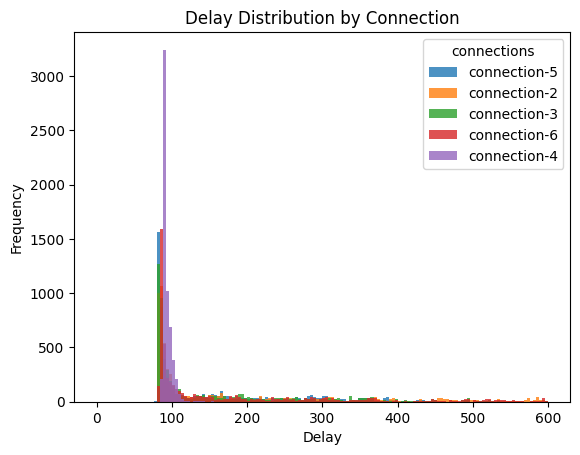

In [204]:
# delay's distribution of the connections
for thread in ws_data['connection_name'].unique():
  plt.hist(ws_data[ws_data['connection_name'] == thread]['delay'], alpha=0.8, label=thread, bins=150, range=(0, 600))

plt.title('Delay Distribution by Connection')
plt.xlabel('Delay')
plt.ylabel('Frequency')

plt.legend(title='connections')
plt.show()

In [205]:
# Fraction of delays that less then 100ms
ws_data[ws_data['delay'] < 200]['u'].count() / ws_data.shape[0]

0.781468888133288

Гистрограмма распределения показывает, что большинство (в моем случае 78.15%) задержек составляют менее 200мс для каждого открытого соединения.

In [206]:
# "fast" connection
# calculate fractions of updateIds that the connection received first
ws_data.sort_values('receive_time').groupby('u').apply(lambda x: x.iloc[0].connection_name).value_counts(normalize=True)

connection-5    0.476709
connection-4    0.338660
connection-3    0.094866
connection-2    0.073104
connection-6    0.016661
Name: proportion, dtype: float64

### Рассуждения и гипотезы
Видим, что одно из соединений получает сообщение быстрее, чем другие. В моем случае connection-5 в 47% случаях получает сообщение быстрее конкурентных сокетов.

Однако сделать вывод на этом наблюдении нельзя - повторные запуски показали, что доля первых сообщений может быть как существенно выше у одного сокета(например, мне удалось зафиксировать наблюдение, когда один сокет в 68%-ах получах сообщение первым), так и распределена равномерно между всеми сокетами. Это значит, что текущая реализация не влияет на то, какой сокет первым получит сообщение. Более того, порядок открытия сокетов при текущей реализации так же не оказывает влияния.

#### Тогда почему же так?
Я определил несколько ключевых точек, которые могут оказывать влияние на скорость получения сокетами одного и того же сообщения. Эти точки связаны с путём, который необходимо пройти сообщению от биржи до конечного пользователя(сокета).
Гипотезы:
1. `Websocket server` НЕ отправляет одновременно сообщение всем клиентам. Многопотчные сокетные сервера будут стараться максимально справедливо поделить клиентов на группы(например, по геолокации датацентров) и разослать новое сообщение параллельно, однако даже такой подход даст разницу во времени.
2. Маршрут, по которому идет сообщение от биржи до клиента может меняться. Сообщение проходит множество узлов прежде, чем попадет к клиенту(чем дальше клиент от сервера - тем больше узлов). Эти узлы могут меняться, поскольку задача сетевой маршрутизации - найти кратчайший(определяется нагруженностью и доступностью узла/ов) маршрут. Если маршрут изменился - время получения сообщения изменится.
3. Последовательность Ethernet'a. Данные передаются пакетами, данные в пакетах записаны последовательно. То, каким по порядку сообщение для конкретного сокета будет записано, определяется на стороне сервера. Соответственно, более вероятно, что сообщение записанное первым в пакет данных от биржи, будет принятно и обработано клиентом раньше.
4. Операционная система и сеть. Сетевая карта, сетевой драйвер и механизмы обработки пакетов данных в ОС безусловно влияют на время получения сообщения сокетом. Так, например, одно ядро ОС работает с процессом, внутри которого слушается сокет. ОС будет знать, на каком ядре искать этот процесс. При смене ядра, на котором находится процесс с сокетом, ОС будет вынуждена лезть в таблицу и искать, куда отдавать пришедшие данные - это займет определенное время. На уровне ОС таких причин можеть быть множество.
5. `asyncio.tasks` выполняются последовательно одна за другой. Да, несмотря на то, что мой код асинхронный, пока одна таска выполняется, другая ждёт. В моем случае 1 сокет - 1 таска, это значит, что, пока 1 таска не обработает все события, пришедшие в сокет, она не передаст управление другой.Так получается что-то типа снежного кома: таска A выполняется и собирает всё, что падает в сокет.
Тогда таски B, C  и D  сидят и ждут. Когда таска А закончит, у тасок B, C  и D уже накопятся сообщения, которые необходимо разобрать. Пусть таска А закончила, и управление перешло таске B. Таска B разбирает всё, что пришло пока выполнялась таска A плюс новые сообщения, которые приходят риал тайм. В это время таски А, C и D ждут. Пусть таска B  закончила и управление перешло таске C. Ей необходимо разобрать все сообщения, которые приходили, пока выполнялись таски A и B плюс те, что приходят риал тайм. Ситуация с таской D аналогична. В данном примере сокет в таске D будет самым медленным. Более того переключение между тасками не самое предсказуемое событие, поэтому утверждать, что передача будет выглядеть следующим образом `A->B->C->D` нельзя. Этот подход влияет на задержку.
Многопоточность не решит эту проблему из-за GIL, а многопроцессность будет жрать много ресурсов.
6. `asyncio.select` - системный вызов, который определяет готовность файловых дискрипторов для чтения/записи. Его реализация зависит от вашей ОС(в моем случае это KqueueSelector). Реализация определит то, какой сокет первым подхватит пришедшее сообщение и выиграет во времени.

## Mean and variance values test

У нас 5 групп, поэтому используем ANOVA-тест для сравнения матожиданий задержек коннекшенов.
Для сравнения стандартных отклонений будем использовать Levene's-тест.

In [207]:
from scipy.stats import f_oneway

groups = []

for connection in ws_data['connection_name'].unique():
  groups.append(ws_data[ws_data['connection_name'] == connection]['delay'].tolist())

f_oneway(*groups)

F_onewayResult(statistic=735.6888729854273, pvalue=0.0)

Результаты теста показали, что матожидания задержек у разных коннекшенов отличаются.

In [208]:
from scipy import stats
stats.levene(*groups)

LeveneResult(statistic=813.5318121054548, pvalue=0.0)

Результаты теста показали, что дисперсии задержек у разных коннекшенов отличаются

При отсутствии системного тестирования каждой из гипотез описанных выше можно утверждать, что результаты статистических тестов подтверждают гипотезу №5:
- Переключение между тасками происходит, когда одна из тасок полностью разберет сокет
- На какую именно таску произойдет переключение мы не можем определить однозначно

In [209]:
ws_data.groupby('connection_name')['delay'].std()

connection_name
connection-2    136.910977
connection-3    109.455498
connection-4      6.615549
connection-5     95.085699
connection-6    230.387884
Name: delay, dtype: float64

In [210]:
ws_data.groupby('connection_name')['delay'].mean()

connection_name
connection-2    174.488916
connection-3    158.417790
connection-4     93.227958
connection-5    152.072134
connection-6    227.582050
Name: delay, dtype: float64

In [190]:
ws_data.groupby('connection_name')['delay'].median()

connection_name
connection-2     96.374146
connection-3     96.519531
connection-4     90.639404
connection-5     94.945068
connection-6    108.265625
Name: delay, dtype: float64

Интересно, что самый быстрый коннекшен (`connection-4`) имеет минимальную дисперсию. Это говорит о том, что время, за которое сообщение дойдет до моей ОС не имеет сильных колебаний. Задержка же образуется внутри ОС, а именно при исполнении кода (гипотеза №5).